<a href="https://colab.research.google.com/github/Risad-Raihan/genai_coursera/blob/main/Attention_Mechanism_positional_encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install packages
! pip install Levenshtein
!pip install torch==2.3.0 torchtext==0.18.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.

In [2]:
import torch # Make sure you import torch first
# Device for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [3]:
import os
import sys
import time
import warnings
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests

from Levenshtein import distance
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

/usr/local/lib/python3.11/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.11/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.11/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [4]:
# Device for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
split = 'train'

# Training parameters
learning_rate = 3e-4
batch_size = 64
max_iters = 5000              # Maximum training iterations
eval_interval = 200           # Evaluate model every 'eval_interval' iterations in the training loop
eval_iters = 100              # When evaluating, approximate loss using 'eval_iters' batches

# Architecture parameters
max_vocab_size = 256          # Maximum vocabulary size
vocab_size = max_vocab_size   # Real vocabulary size (e.g. BPE has a variable length, so it can be less than 'max_vocab_size')
block_size = 16               # Context length for predictions
n_embd = 32                   # Embedding size
num_heads = 2                 # Number of head in multi-headed attention
n_layer = 2                   # Number of Blocks
ff_scale_factor = 4           # Note: The '4' magic number is from the paper: In equation 2 uses d_model=512, but d_ff=2048
dropout = 0.0                 # Normalization using dropout# 10.788929 M parameters

head_size = n_embd // num_heads
assert (num_heads * head_size) == n_embd

In [5]:
def plot_embdings(my_embdings,name,vocab):

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Plot the data points
  ax.scatter(my_embdings[:,0], my_embdings[:,1], my_embdings[:,2])

  # Label the points
  for j, label in enumerate(name):
      i=vocab.get_stoi()[label]
      ax.text(my_embdings[j,0], my_embdings[j,1], my_embdings[j,2], label)

  # Set axis labels
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')

  # Show the plot
  plt.show()

In [6]:
dictionary = {
    'le': 'the'
    , 'chat': 'cat'
    , 'est': 'is'
    , 'sous': 'under'
    , 'la': 'the'
    , 'table': 'table'
}

In [7]:
# Function to split a sentence into tokens (words)
def tokenize(text):
    """
    This function takes a string of text as input and returns a list of words (tokens).
    It uses the split method, which by default splits on any whitespace, to tokenize the text.
    """
    return text.split()  # Split the input text on whitespace and return the list of tokens

# Function to translate a sentence from source to target language word by word
def translate(sentence):
    """
    This function translates a sentence by looking up each word's translation in a predefined dictionary.
    It assumes that every word in the sentence is a key in the dictionary.
    """
    out = ''  # Initialize the output string
    for token in tokenize(sentence):  # Tokenize the sentence into words
        # Append the translated word to the output string
        # This line assumes the dictionary contains a translation for every word in the input
        out += dictionary[token] + ' '
    return out.strip()  # Return the translated sentence, stripping any extra whitespace

In [8]:
translate("le chat est sous la table")

'the cat is under the table'

In [9]:
# Function to find the closest key in the dictionary to the given query word
def find_closest_key(query):
    """
    The function computes the Levenshtein distance between the query and each key in the dictionary.
    The Levenshtein distance is a measure of the number of single-character edits required to change one word into the other.
    """
    closest_key, min_dist = None, float('inf')  # Initialize the closest key and minimum distance to infinity
    for key in dictionary.keys():
        dist = distance(query, key)  # Calculate the Levenshtein distance to the current key
        if dist < min_dist:  # If the current distance is less than the previously found minimum
            min_dist, closest_key = dist, key  # Update the minimum distance and the closest key
    return closest_key  # Return the closest key found

# Function to translate a sentence from source to target language using the dictionary
def translate(sentence):
    """
    This function tokenizes the input sentence into words and finds the closest translation for each word.
    It constructs the translated sentence by appending the translated words together.
    """
    out = ''  # Initialize the output string
    for query in tokenize(sentence):  # Tokenize the sentence into words
        key = find_closest_key(query)  # Find the closest key in the dictionary for each word
        out += dictionary[key] + ' '  # Append the translation of the closest key to the output string
    return out.strip()  # Return the translated sentence, stripping any extra whitespace

In [10]:
translate("tables")

'table'

# **Convert to Neural Network**

In [11]:
# Create and sort the input vocabulary from the dictionary's keys
vocabulary_in = sorted(list(set(dictionary.keys())))
# Display the size and the sorted vocabulary for the input language
print(f"Vocabulary input ({len(vocabulary_in)}): {vocabulary_in}")

# Create and sort the output vocabulary from the dictionary's values
vocabulary_out = sorted(list(set(dictionary.values())))
# Display the size and the sorted vocabulary for the output language
print(f"Vocabulary output ({len(vocabulary_out)}): {vocabulary_out}")

Vocabulary input (6): ['chat', 'est', 'la', 'le', 'sous', 'table']
Vocabulary output (5): ['cat', 'is', 'table', 'the', 'under']


In [12]:
# Function to convert a list of vocabulary words into one-hot encoded vectors
def encode_one_hot(vocabulary):
    vocabulary_size = len(vocabulary)  # Get the size of the vocabulary
    one_hot = dict()  # Initialize a dictionary to hold our one-hot encodings
    LEN = len(vocabulary)  # The length of each one-hot encoded vector will be equal to the vocabulary size

    # Iterate over the vocabulary to create a one-hot encoded vector for each word
    for i, key in enumerate(vocabulary):
        one_hot_vector = torch.zeros(LEN)  # Start with a vector of zeros
        one_hot_vector[i] = 1  # Set the i-th position to 1 for the current word
        one_hot[key] = one_hot_vector  # Map the word to its one-hot encoded vector
        print(f"{key}\t: {one_hot[key]}")  # Print each word and its encoded vector

    return one_hot  # Return the dictionary of words and their one-hot encoded vectors

In [13]:
# Apply the one-hot encoding function to the input vocabulary and store the result
one_hot_in = encode_one_hot(vocabulary_in)

chat	: tensor([1., 0., 0., 0., 0., 0.])
est	: tensor([0., 1., 0., 0., 0., 0.])
la	: tensor([0., 0., 1., 0., 0., 0.])
le	: tensor([0., 0., 0., 1., 0., 0.])
sous	: tensor([0., 0., 0., 0., 1., 0.])
table	: tensor([0., 0., 0., 0., 0., 1.])


In [14]:
# Iterate over the one-hot encoded input vocabulary and print each vector
# This visualizes the one-hot representation for each word in the input vocabulary
for k, v in one_hot_in.items():
    print(f"E_{{ {k} }} = " , v)

E_{ chat } =  tensor([1., 0., 0., 0., 0., 0.])
E_{ est } =  tensor([0., 1., 0., 0., 0., 0.])
E_{ la } =  tensor([0., 0., 1., 0., 0., 0.])
E_{ le } =  tensor([0., 0., 0., 1., 0., 0.])
E_{ sous } =  tensor([0., 0., 0., 0., 1., 0.])
E_{ table } =  tensor([0., 0., 0., 0., 0., 1.])


In [15]:
# Apply the one-hot encoding function to the output vocabulary and store the result
# This time we're encoding the target language vocabulary
one_hot_out = encode_one_hot(vocabulary_out)

cat	: tensor([1., 0., 0., 0., 0.])
is	: tensor([0., 1., 0., 0., 0.])
table	: tensor([0., 0., 1., 0., 0.])
the	: tensor([0., 0., 0., 1., 0.])
under	: tensor([0., 0., 0., 0., 1.])


In [16]:
# Stacking the one-hot encoded vectors for input vocabulary to form a tensor
K = torch.stack([one_hot_in[k] for k in dictionary.keys()])
# K now represents a matrix of one-hot vectors for the input vocabulary

# Display the tensor for verification
print(K)

tensor([[0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]])


In [17]:
# Similarly, stack the one-hot encoded vectors for output vocabulary to form a tensor
V = torch.stack([one_hot_out[k] for k in dictionary.values()])
# V represents the corresponding matrix of one-hot vectors for the output vocabulary

# Display the tensor for verification
print(V)

tensor([[0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.]])


In [18]:
# Demonstrating how to look up a translation for a given word using matrix operations
# Here, we take the one-hot representation of 'sous' from the input vocabulary
q = one_hot_in['sous']
# Display the query token vector
print("Query token :", q)

Query token : tensor([0., 0., 0., 0., 1., 0.])


In [19]:
# Select the corresponding key vector in K (input dictionary matrix) using matrix multiplication
# This operation gives us the index where 'sous' would be '1' in the one-hot encoded input matrix
print("Select key (K) :", q @ K.T)

Select key (K) : tensor([0., 0., 0., 1., 0., 0.])


In [20]:
# Use the index found from the key selection to find the corresponding value vector in V (output dictionary matrix)
# This operation selects the row from V that is the translation of 'sous' in the output vocabulary
print("Select value (V):", q @ K.T @ V)

# The final output demonstrates how 'sous' can be translated using the neural network approach

Select value (V): tensor([0., 0., 0., 0., 1.])


# Decode one hot vector

In [21]:
def decode_one_hot(one_hot, vector):
    """
    Decode a one-hot encoded vector to find the best matching token in the vocabulary.
    """
    best_key, best_cosine_sim = None, 0
    for k, v in one_hot.items():  # Iterate over the one-hot encoded vocabulary
        cosine_sim = torch.dot(vector, v)  # Calculate dot product (cosine similarity)
        if cosine_sim > best_cosine_sim:  # If this is the best similarity we've found
            best_cosine_sim, best_key = cosine_sim, k  # Update the best similarity and token
    return best_key  # Return the token corresponding to the one-hot vector

In [22]:
def translate(sentence):
    """
    Translate a sentence using matrix multiplication, treating the dictionaries as matrices.
    """
    sentence_out = ''  # Initialize the output sentence
    for token_in in tokenize(sentence):  # Tokenize the input sentence
        q = one_hot_in[token_in]  # Find the one-hot vector for the token
        out = q @ K.T @ V  # Multiply with the input and output matrices to find the translation
        token_out = decode_one_hot(one_hot_out, out)  # Decode the output one-hot vector to a token
        sentence_out += token_out + ' '  # Append the translated token to the output sentence
    return sentence_out.strip()  # Return the translated sentence

In [23]:
translate("le chat est sous la table")

'the cat is under the table'

# **Softmax for similarity**

In [24]:
print('E_{table} = ', one_hot_in['table'])

E_{table} =  tensor([0., 0., 0., 0., 0., 1.])


In [25]:
def translate(sentence):
    """
    Translate a sentence using the attention mechanism represented by the K and V matrices.
    The softmax function is used to calculate a weighted sum of the V vectors, focusing on the most relevant vector for translation.
    """
    sentence_out = ''  # Initialize the output sentence
    for token_in in tokenize(sentence):  # Tokenize the input sentence
        q = one_hot_in[token_in]  # Get the one-hot vector for the current token
        # Apply softmax to the scaled dot product of q and K.T, then multiply by V
        # This selects the most relevant translation vector from V
        out = torch.softmax(q @ K.T, dim=0) @ V
        token_out = decode_one_hot(one_hot_out, out)  # Decode the output vector to a token
        sentence_out += token_out + ' '  # Append the translated token to the output sentence
    return sentence_out.strip()  # Return the translated sentence

# Test the translate function
translate("le chat est sous la table")

'the cat is under the table'

In [26]:
# The sentence we want to translate
sentence = "le chat est sous la table"

# Stack all the one-hot encoded vectors for the tokens in the sentence to form the Q matrix
Q = torch.stack([one_hot_in[token] for token in tokenize(sentence)])

# Display the Q matrix
print(Q)

tensor([[0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]])


In [27]:
def translate(sentence):
    """
    Translate a sentence using matrix multiplication in parallel.
    This function replaces the iterative approach with a single matrix multiplication step,
    applying the attention mechanism across all tokens at once.
    """
    # Tokenize the sentence and stack the one-hot vectors to form the Q matrix
    Q = torch.stack([one_hot_in[token] for token in tokenize(sentence)])

    # Apply softmax to the dot product of Q and K.T and multiply by V
    # This will give us the output vectors for all tokens in parallel
    out = torch.softmax(Q @ K.T, 0) @ V

    # Decode each one-hot vector in the output to the corresponding token
    # And join the tokens to form the translated sentence
    return ' '.join([decode_one_hot(one_hot_out, o) for o in out])

# Test the function to ensure it produces the correct translation
translate("le chat est sous la table")

'the cat is under the table'

# **Self Attention**

In [28]:
class Head(nn.Module):
    """ Self attention head. This class implements a self-attention mechanism
        which is a key component of transformer-based neural network architectures. """

    def __init__(self):
        super().__init__()  # Initialize the superclass (nn.Module)
        # Embedding layer to convert input token indices to vectors of fixed size (n_embd)
        self.embedding = nn.Embedding(vocab_size, n_embd)
        # Linear layers to compute the queries, keys, and values from the embeddings
        self.key = nn.Linear(n_embd, n_embd, bias=False)
        self.query = nn.Linear(n_embd, n_embd, bias=False)
        self.value = nn.Linear(n_embd, n_embd, bias=False)

    def attention(self, x):
        embedded_x = self.embedding(x)
        k = self.key(embedded_x)
        q = self.query(embedded_x)
        v = self.value(embedded_x)
        # Attention score
        w = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5   # Query * Keys / normalization
        w = F.softmax(w, dim=-1)  # Do a softmax across the last dimesion
        return embedded_x,k,q,v,w

    def forward(self, x):
        embedded_x = self.embedding(x)
        k = self.key(embedded_x)
        q = self.query(embedded_x)
        v = self.value(embedded_x)
        # Attention score
        w = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5   # Query * Keys / normalization
        w = F.softmax(w, dim=-1)  # Do a softmax across the last dimesion
        # Add weighted values
        out = w @ v
        return out

In [29]:
dataset = [
    (1,"Introduction to NLP"),
    (2,"Basics of PyTorch"),
    (1,"NLP Techniques for Text Classification"),
    (3,"Named Entity Recognition with PyTorch"),
    (3,"Sentiment Analysis using PyTorch"),
    (3,"Machine Translation with PyTorch"),
    (1," NLP Named Entity,Sentiment Analysis,Machine Translation "),
    (1," Machine Translation with NLP "),
    (1," Named Entity vs Sentiment Analysis  NLP "),
    (3,"he painted the car red"),
    (1,"he painted the red car")
    ]

In [30]:
tokenizer = get_tokenizer("basic_english")  # Get a basic English tokenizer

In [31]:
def yield_tokens(data_iter):
    """Yield list of tokens in the dataset."""
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])  # Set default index for unknown words

In [32]:
def text_pipeline(x):
    """Converts a text string to a list of token indices."""
    return vocab(tokenizer(x))  # Tokenize the input and map each token to its index in the vocabulary

In [33]:
vocab_size = len(vocab)  # Total number of tokens in the vocabulary
n_embd = 3  # Dimension of the embedding space

# Create the attention head with the integrated embedding layer
attention_head = Head()

Dummy data for testing

In [34]:
# Define the sentence to be tokenized and converted to indices
my_tokens = 'he painted the car red'
# Apply the text pipeline to the sentence to get token indices
input_data = torch.tensor(text_pipeline(my_tokens), dtype=torch.long)

# Print out the shape and the token indices tensor
print(input_data.shape)
print(input_data)

torch.Size([5])
tensor([12, 13, 15, 11, 14])


In [35]:
# Pass the tokenized input data through the embedding layer and the attention mechanism of the Head class
embedded_x, k, q, v, w = attention_head.attention(input_data)

# Print the size of the resulting embedded vector for verification
print(embedded_x.shape)  # Should show the shape as [number of tokens, embedding dimension]
print("embedded_x:", embedded_x)  # The actual embedded representations of the input tokens

torch.Size([5, 3])
embedded_x: tensor([[ 0.7280, -1.5229,  0.3218],
        [ 1.1674,  0.9367,  0.9137],
        [-2.5858,  1.6030, -0.5559],
        [ 0.6826, -1.8526, -1.8525],
        [-0.8342,  0.1827,  0.5550]], grad_fn=<EmbeddingBackward0>)


In [36]:
# Print the shapes of the key, query, value, and attention weight matrices
# This helps verify the dimensions are as expected for the attention calculations
print("k:", k.shape)  # The shape of the keys tensor
print("q:", q.shape)  # The shape of the queries tensor
print("v:", v.shape)  # The shape of the values tensor
print("w:", w.shape)  # The shape of the attention weights tensor

k: torch.Size([5, 3])
q: torch.Size([5, 3])
v: torch.Size([5, 3])
w: torch.Size([5, 5])


In [37]:
# Now we actually pass the input data through the entire attention head to get the output
output = attention_head(input_data)

# Print the output and its shape, which should match the shape of the input
# The output tensor contains the final attention-applied representations of the input
print(output.shape)
print(output)

torch.Size([5, 3])
tensor([[ 0.2454,  0.6371, -0.2537],
        [ 0.0911,  0.0294,  0.0132],
        [-1.1976, -1.3826,  0.6359],
        [ 0.3326,  0.9502, -0.4094],
        [-0.4706, -0.5535,  0.2733]], grad_fn=<MmBackward0>)


# **Positional encoding**

In [38]:
# Generate a range of position indices from 0 to the size of the vocabulary
position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)

# Retrieve the list of words from the vocabulary object
vocab_list = list(vocab.get_itos())

# Iterate over the range of vocabulary size
for idx in range(vocab_size):
    word = vocab_list[idx]  # Get the word from the vocabulary list at the current index
    pos = position[idx][0].item()  # Extract the numerical value of the position index from the tensor
    print(f"Word: {word}, Position Index: {pos}")

Word: <unk>, Position Index: 0.0
Word: nlp, Position Index: 1.0
Word: pytorch, Position Index: 2.0
Word: analysis, Position Index: 3.0
Word: entity, Position Index: 4.0
Word: machine, Position Index: 5.0
Word: named, Position Index: 6.0
Word: sentiment, Position Index: 7.0
Word: translation, Position Index: 8.0
Word: with, Position Index: 9.0
Word: ,, Position Index: 10.0
Word: car, Position Index: 11.0
Word: he, Position Index: 12.0
Word: painted, Position Index: 13.0
Word: red, Position Index: 14.0
Word: the, Position Index: 15.0
Word: basics, Position Index: 16.0
Word: classification, Position Index: 17.0
Word: for, Position Index: 18.0
Word: introduction, Position Index: 19.0
Word: of, Position Index: 20.0
Word: recognition, Position Index: 21.0
Word: techniques, Position Index: 22.0
Word: text, Position Index: 23.0
Word: to, Position Index: 24.0
Word: using, Position Index: 25.0
Word: vs, Position Index: 26.0


In [39]:
# Initialize a matrix of zeros with dimensions [vocab_size, n_embd]
# This will be used to hold the positional encodings for each word in the vocabulary
pe = torch.zeros(vocab_size, n_embd)

# Concatenate the position tensor three times along dimension 1 (columns)
# This simplistic example is likely a placeholder for a more complex function of position that would be used in a real positional encoding
pe = torch.cat((position, position, position), 1)

# Display the positional encoding tensor
# In an actual implementation, this would involve a more sophisticated method that reflects the position's impact on the embeddings
pe

tensor([[ 0.,  0.,  0.],
        [ 1.,  1.,  1.],
        [ 2.,  2.,  2.],
        [ 3.,  3.,  3.],
        [ 4.,  4.,  4.],
        [ 5.,  5.,  5.],
        [ 6.,  6.,  6.],
        [ 7.,  7.,  7.],
        [ 8.,  8.,  8.],
        [ 9.,  9.,  9.],
        [10., 10., 10.],
        [11., 11., 11.],
        [12., 12., 12.],
        [13., 13., 13.],
        [14., 14., 14.],
        [15., 15., 15.],
        [16., 16., 16.],
        [17., 17., 17.],
        [18., 18., 18.],
        [19., 19., 19.],
        [20., 20., 20.],
        [21., 21., 21.],
        [22., 22., 22.],
        [23., 23., 23.],
        [24., 24., 24.],
        [25., 25., 25.],
        [26., 26., 26.]])

In [40]:
# Obtain the shape of the embedded_x tensor which contains the embedded representations
# 'samples' will hold the number of tokens/samples in the batch
# 'dim' will hold the dimensionality of the embeddings
samples, dim = embedded_x.shape

# Print the tuple (samples, dim) to show the size of the batch and the embedding dimension
samples, dim

(5, 3)

In [41]:
# Select the appropriate positional encodings based on the number of samples and embedding dimensions
# This slice of the positional encoding tensor 'pe' corresponds to the actual batch size and embedding size
pe_slice = pe[0:samples, 0:n_embd]

In [42]:
# Add the positional encodings to the token embeddings
# This step integrates the position information into the embeddings
pos_embding = embedded_x + pe_slice

# The result 'pos_embding' now contains the token embeddings adjusted with positional information
# Display the adjusted embeddings tensor
pos_embding

tensor([[ 0.7280, -1.5229,  0.3218],
        [ 2.1674,  1.9367,  1.9137],
        [-0.5858,  3.6030,  1.4441],
        [ 3.6826,  1.1474,  1.1475],
        [ 3.1658,  4.1827,  4.5550]], grad_fn=<AddBackward0>)

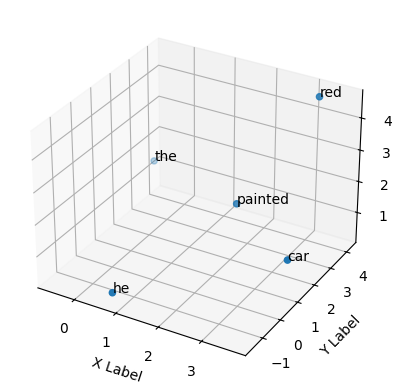

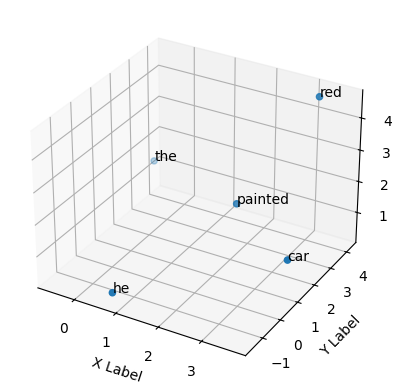

In [43]:
# Visualize the embeddings with positional encodings using the defined plot function
# 'pos_embding.detach().numpy()' converts the embeddings tensor to a NumPy array and detaches it from the current computation graph
# 'tokenizer(my_tokens)' tokenizes the sample sentence for labeling in the plot
# 'vocab' is passed to associate tokens with their embeddings for plotting
plot_embdings(pos_embding.detach().numpy(), tokenizer(my_tokens), vocab)
plot_embdings(pos_embding.detach().numpy(),tokenizer(my_tokens),vocab)

In [44]:
pos_embding[3]# add -3 to get original embedding

tensor([3.6826, 1.1474, 1.1475], grad_fn=<SelectBackward0>)

In [45]:
pos_embding[-1]#add -9 original embedding

tensor([3.1658, 4.1827, 4.5550], grad_fn=<SelectBackward0>)

In [46]:
pe=torch.cat((0.1*position, -0.1*position, 0*position), 1)

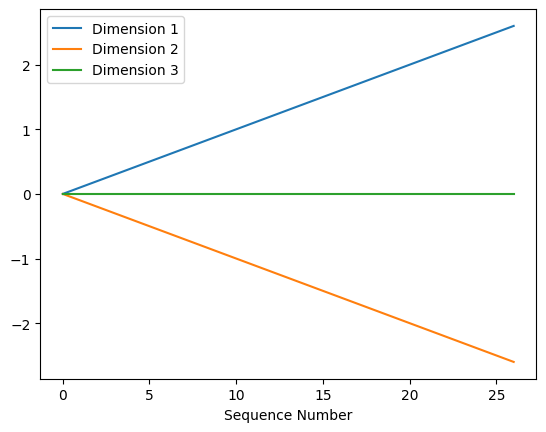

In [47]:
# Plot the first dimension of positional encodings for all positions in the sequence
plt.plot(pe[:, 0].numpy(), label="Dimension 1")

# Plot the second dimension of positional encodings for all positions in the sequence
plt.plot(pe[:, 1].numpy(), label="Dimension 2")

# Plot the third dimension of positional encodings for all positions in the sequence
plt.plot(pe[:, 2].numpy(), label="Dimension 3")

# Label the x-axis as 'Sequence Number' to represent the position in the sequence
plt.xlabel("Sequence Number")

# Add a legend to the plot to identify which line corresponds to which dimension of positional encoding
plt.legend()

# Display the plot on screen
plt.show()

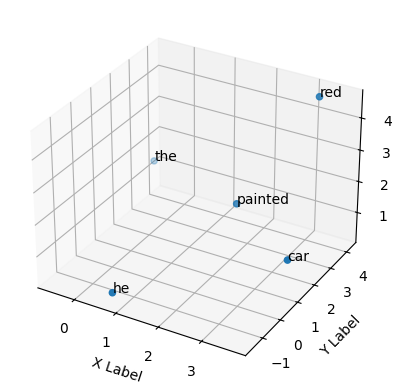

In [48]:
# After the positional encodings have been added, we need to detach the tensor from the computation graph
# and convert it to a NumPy array for visualization
# 'detach()' is necessary because 'embedded_x' requires gradients and we don't need them for plotting
# 'numpy()' converts the PyTorch tensor to a NumPy array
pos_embding_numpy = pos_embding.detach().numpy()

# Tokenize the sample sentence to use as labels in the plot
tokens = tokenizer(my_tokens)

# Visualize the token embeddings with positional encodings
# The 'plot_embdings' function presumably takes the NumPy array of embeddings, token labels, and a vocabulary
# to plot the embeddings in a space where similar embeddings are closer together
plot_embdings(pos_embding_numpy, tokens, vocab)

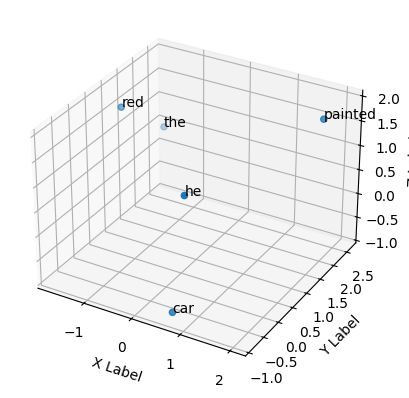

In [49]:
# Generate positional encodings using a sinusoidal function and concatenation
# The first dimension is encoded with a sine function
# The second and third dimensions are placeholders and are simply set to 1 (this is not typical in practice and likely serves as a simplified example)
pe = torch.cat((torch.sin(2 * 3.14 * position / 6),  # Sinusoidal encoding for dimension 1
                0 * position + 1,                     # Constant encoding (1) for dimension 2
                0 * position + 1), axis=1)            # Constant encoding (1) for dimension 3

# Add the sinusoidal positional encodings to the token embeddings
# This step enriches the embeddings with information about the position of each token in the sequence
pos_embding = embedded_x + pe[0:samples, :]

# Prepare the positional embeddings for visualization
# 'detach()' is used to stop tracking all operations on 'pos_embding'
# 'numpy()' converts the tensor to a NumPy array suitable for plotting
pos_embding_numpy = pos_embding.detach().numpy()

# Tokenize the sample sentence to get the labels for the embedding plot
tokens = tokenizer(my_tokens)

# Visualize the embeddings using the plot function
# It is assumed the function will plot these embeddings in a way that illustrates the effects of adding positional encodings
plot_embdings(pos_embding_numpy, tokens, vocab)

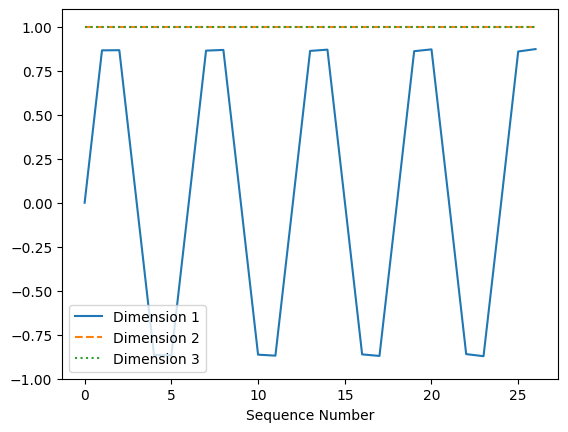

In [50]:
# Plot the positional encodings with different line styles and markers
plt.plot(pe[:, 0].numpy(), label="Dimension 1", linestyle='-')
plt.plot(pe[:, 1].numpy(), label="Dimension 2", linestyle='--')
plt.plot(pe[:, 2].numpy(), label="Dimension 3", linestyle=':')

# Adjust the y-axis scale for better visibility
plt.ylim([-1, 1.1])

plt.xlabel("Sequence Number")
plt.legend()
plt.show()

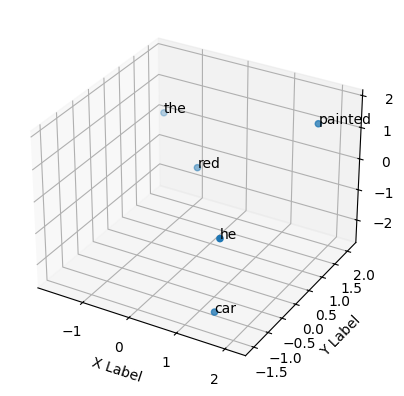

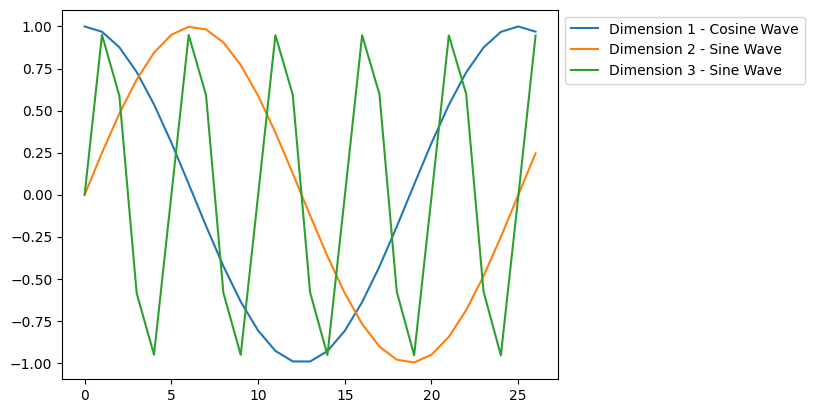

In [51]:
# Create positional encodings using sinusoidal functions
# Concatenate cosine and sine functions for different dimensions to form the encoding
pe = torch.cat((torch.cos(2 * 3.14 * position / 25),  # Cosine function for the first dimension
                torch.sin(2 * 3.14 * position / 25),  # Sine function for the second dimension
                torch.sin(2 * 3.14 * position / 5)), axis=1)  # Sine function with different frequency for the third dimension

# Add the generated positional encodings to the token embeddings
# This enriches the embeddings with positional information
pos_embding = embedded_x + pe[0:samples, :]

# Detach the embeddings from the computational graph and convert to NumPy for visualization
pos_embding_numpy = pos_embding.detach().numpy()

# Tokenize the input text to be used as labels in the plot
tokens = tokenizer(my_tokens)

# Visualize the embeddings with positional encodings
plot_embdings(pos_embding_numpy, tokens, vocab)

# Additionally, plot each dimension of the positional encodings to visualize their patterns
plt.plot(pe[:, 0].numpy(), label="Dimension 1 - Cosine Wave")
plt.plot(pe[:, 1].numpy(), label="Dimension 2 - Sine Wave")
plt.plot(pe[:, 2].numpy(), label="Dimension 3 - Sine Wave")

# Add a legend in the upper left corner outside of the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()

In [52]:
class PositionalEncoding(nn.Module):
    """Positional encoding module injects some information about the relative or absolute position of the tokens in the sequence."""
    def __init__(self, n_embd, vocab_size, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        # Initialize a buffer for the positional encodings (not a parameter, so it's not updated during training)
        pe = torch.zeros(vocab_size, n_embd)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        # Calculate the positional encodings once in log space
        pe = torch.cat((torch.cos(2 * 3.14 * position / 25), torch.sin(2 * 3.14 * position / 25), torch.sin(2 * 3.14 * position / 5)), 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to each embedding vector assuming x is (seq_len, batch_size, n_embd)
        # Note: 'pe' is a registered buffer and does not require gradients
        pos = x + self.pe[:x.size(0), :]
        return pos

class Head(nn.Module):
    """Self attention head."""
    def __init__(self, n_embd, vocab_size):
        super().__init__()
        # An embedding layer that converts input data (token indices) into dense vectors of fixed size
        self.embedding = nn.Embedding(vocab_size, n_embd)
        # The positional encoding layer
        self.pos_encoder = PositionalEncoding(n_embd, vocab_size)
        # Layers to transform the position-encoded embeddings into queries, keys, and values
        self.key = nn.Linear(n_embd, n_embd, bias=False)
        self.query = nn.Linear(n_embd, n_embd, bias=False)
        self.value = nn.Linear(n_embd, n_embd, bias=False)

    def forward(self, x):
        # Pass the input through the embedding layer to get fixed size dense embeddings
        embedded_x = self.embedding(x)
        # Pass the embeddings through the positional encoder
        p_encoded_x = self.pos_encoder(embedded_x)
        # Generate queries, keys, and values for the attention
        k = self.key(p_encoded_x)
        q = self.query(p_encoded_x)
        v = self.value(p_encoded_x)
        # Calculate the attention scores as the dot product of queries and keys
        w = q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5  # Query * Keys / normalization
        # Apply the softmax function to the attention scores to get probabilities
        w = F.softmax(w, dim=-1)
        # Multiply the attention weights with the values to get the output
        out = w @ v
        return out

In [53]:
# Instantiate the Head class with embedding dimension and vocabulary size as parameters
transformer = Head(n_embd, vocab_size)

# Pass the input data through the transformer model to obtain the output
# This process includes embedding the input, adding positional encodings, and applying self-attention
out = transformer(input_data)

# Print the shape of the output tensor
# The shape will provide insight into how the data has been transformed through the model
print("Output shape:", out.shape)

# Display the output tensor itself
# This output represents the transformed data after applying the embedding, positional encoding, and self-attention mechanisms
print("Output:", out)

Output shape: torch.Size([5, 3])
Output: tensor([[ 0.0909,  0.3089, -0.3009],
        [ 0.1081,  0.1620, -0.2193],
        [ 0.0770,  0.1504, -0.1254],
        [ 0.0912,  0.1391, -0.2060],
        [ 0.1142, -0.0452, -0.3305]], grad_fn=<MmBackward0>)


Transformer in pytorch

In [54]:
transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)

In [55]:
src = torch.rand((10, 32, 512))
tgt = torch.rand((20, 32, 512))

In [56]:
out = transformer_model(src, tgt)

Multihead Attention

In [57]:

# Embedding dimension
embed_dim =4
# Number of attention heads
num_heads = 2
print("should be zero:",embed_dim %num_heads)
# Initialize MultiheadAttention
multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads,batch_first=False)

should be zero: 0


In [58]:
seq_length = 10 # Sequence length
batch_size = 5 # Batch size
query = torch.rand((seq_length, batch_size, embed_dim))
key = torch.rand((seq_length, batch_size, embed_dim))
value = torch.rand((seq_length, batch_size, embed_dim))
# Perform multi-head attention
attn_output, _= multihead_attn(query, key, value)
print("Attention Output Shape:", attn_output.shape)

Attention Output Shape: torch.Size([10, 5, 4])


Transformer encoder layer

In [59]:
# Embedding dimension
embed_dim = 4
# Number of attention h
num_heads = 2
# Checking if the embedding dimension is divisible by the number of heads, print("should be zero", embed_dim % num_h
# Number of encoder layers
num_layers = 6
# Initialize the encoder layer with specified embedding dimension and number of heads.
encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
# Build the transformer encoder by stacking the encoder layer 6 times.
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

In [60]:
# Define sequence length as 10 and batch size as 5 for the input data.
seq_length = 10 # Sequence length
batch_size = 5 # Batch size
# Generate random input tensor to simulate input embeddings for the transformer encoder.
x = torch.rand((seq_length, batch_size, embed_dim))
# Apply the transformer encoder to the input
encoded = transformer_encoder(x)
# Output the shape of the encoded tensor to verify the transformation.
print("Encoded Tensor Shape:", encoded.shape)

Encoded Tensor Shape: torch.Size([10, 5, 4])
